In [1]:
# 1. Load and Explore Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("/content/drive/MyDrive/Concept and Technology of AI/BankChurners.csv")
data = data.drop(columns=[
    'CLIENTNUM',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
])

print("Dataset shape:", data.shape)
print(data.info())
print(data.isnull().sum())
print(data.head())


Dataset shape: (10127, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 no

In [2]:
target_col = 'Attrition_Flag'
X = data.drop(columns=[target_col])
y = data[target_col]

y = y.map({'Existing Customer': 0, 'Attrited Customer': 1})


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [4]:
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [6]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

logreg = LogisticRegression(max_iter=1000)

rfe = RFE(logreg, n_features_to_select=5)
rfe.fit(X_train_processed, y_train)

selected_features = feature_names[rfe.support_]
print("Top 5 Selected Features:", selected_features)


Top 5 Selected Features: ['num__Total_Relationship_Count' 'num__Total_Revolving_Bal'
 'num__Total_Trans_Amt' 'num__Total_Trans_Ct' 'num__Total_Ct_Chng_Q4_Q1']


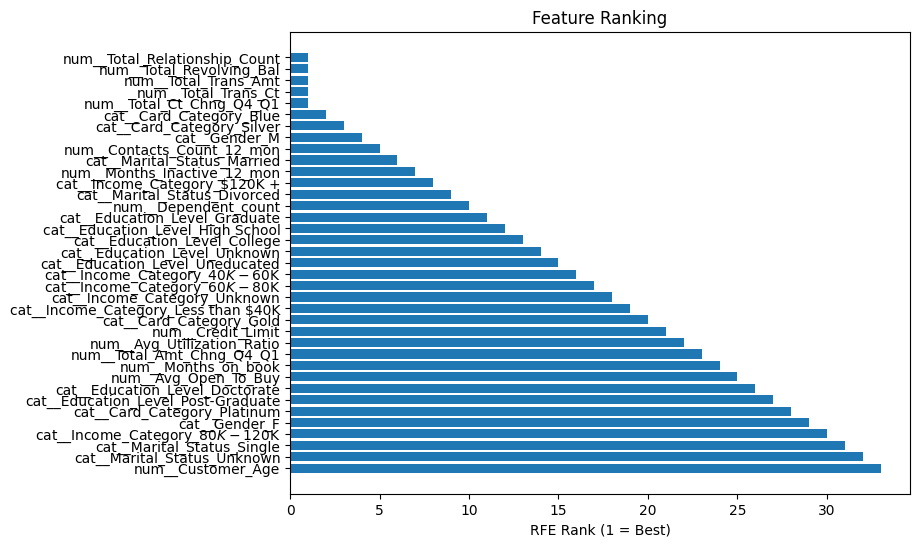

In [8]:
ranking = pd.DataFrame({
    'Feature': feature_names,
    'Rank': rfe.ranking_
}).sort_values('Rank')

plt.figure(figsize=(8,6))
plt.barh(ranking['Feature'], ranking['Rank'])
plt.xlabel("RFE Rank (1 = Best)")
plt.title("Feature Ranking")
plt.gca().invert_yaxis()
plt.show()


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix

logreg.fit(X_train_processed[:, rfe.support_], y_train)

y_pred = logreg.predict(X_test_processed[:, rfe.support_])
y_pred_proba = logreg.predict_proba(X_test_processed[:, rfe.support_])

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba[:,1]))

print("\nClassification Report\n", classification_report(y_test, y_pred))


Accuracy: 0.8968410661401777
Precision: 0.7710280373831776
Recall: 0.5076923076923077
F1 Score: 0.6122448979591837
ROC-AUC: 0.8969927192149415

Classification Report
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1701
           1       0.77      0.51      0.61       325

    accuracy                           0.90      2026
   macro avg       0.84      0.74      0.78      2026
weighted avg       0.89      0.90      0.89      2026



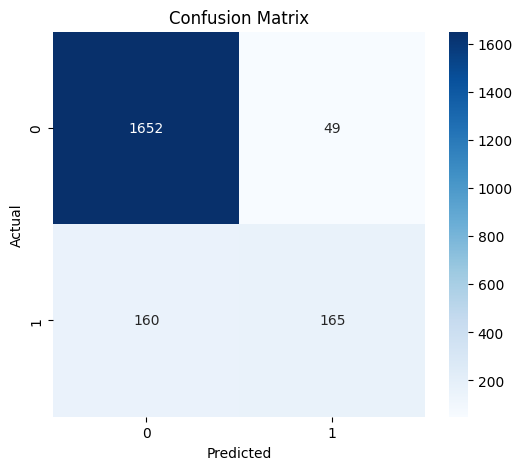

In [10]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
